<a href="https://colab.research.google.com/github/yongcai0/hello-world/blob/master/liangzp0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!pwd
!ls

/content
drive  sample_data


In [0]:
cd drive

/content/drive


In [0]:
cd 'My Drive'

/content/drive/My Drive


In [0]:
ls chinaresult/PG/train

config.json


In [0]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug  6 08:59:35 2018
@author: Administrator
"""
import tensorflow as tf
from collections import deque
import numpy as np
import random

tf_summaries_list=[]

def res_block(x,trainable):

    x_shortcut=x

    conv1_W = tf.Variable(tf.random_normal([1, 1, 32, 32], stddev=0.15), trainable=trainable)
    x = tf.nn.conv2d(x, filter=conv1_W, strides=[1, 1, 1, 1], padding='SAME')
    x = tf.layers.batch_normalization(x)
    x = tf.nn.relu(x)

    conv2_W = tf.Variable(tf.random_normal([1, 1, 32, 32], stddev=0.15), trainable=trainable)
    x = tf.nn.conv2d(x, filter=conv2_W, strides=[1, 1, 1, 1], padding='SAME')
    x = tf.layers.batch_normalization(x)
    x=tf.add(x,x_shortcut)
    x = tf.nn.relu(x)

    return x


def build_predictor(inputs, predictor, nes_num,scope,trainable):
    with tf.name_scope(scope):
        if predictor == 'CNN':

            L=int(inputs.shape[2])
            N = int(inputs.shape[3])

            conv1_W = tf.Variable(tf.truncated_normal([1,L,N,32], stddev=0.15), trainable=trainable)
            layer = tf.nn.conv2d(inputs, filter=conv1_W, padding='VALID', strides=[1, 1, 1, 1])
            norm1 = tf.layers.batch_normalization(layer)
            x = tf.nn.relu(norm1)

            conv3_W = tf.Variable(tf.random_normal([1, 1, 32, 1], stddev=0.15), trainable=trainable)
            conv3 = tf.nn.conv2d(x, filter=conv3_W, strides=[1, 1, 1, 1], padding='VALID')
            norm3 = tf.layers.batch_normalization(conv3)
            net = tf.nn.relu(norm3)

            net=tf.layers.flatten(net)

            return net

def variables_summaries(var,name):
    mean=tf.reduce_mean(var)

    tf.summary.scalar(name+'_mean',mean)

    std=tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
    tf.summary.scalar(name+'_stddev',std)

    tf.summary.histogram(name+'_histogram',var)


class StockActor:
    def __init__(self,sess,predictor,M,L,N):

        #Initial hyperparaters
        self.tau=10e-3
        self.learning_rate=10e-2
        self.gamma=0.99

        #Initial session
        self.sess=sess

        #Initial input shape
        self.M=M
        self.L=L
        self.N=N

        self.init_input()
        self.scopes=['online/actor','target/actor']
        self.inputs,self.out,self.previous_action=self.build_actor(predictor,self.scopes[0],True)
        self.target_inputs, self.target_out,self.target_previous_action=self.build_actor(predictor,self.scopes[1],False)

        self.init_op()

        self.action_gradient=tf.placeholder(tf.float32,[None]+[self.M])
        self.unnormalized_actor_gradients=tf.gradients(self.out,self.network_params,-self.action_gradient)
        self.actor_gradients =self.unnormalized_actor_gradients#list(map(lambda x: tf.div(x, self.batch_size), self.unnormalized_actor_gradients))#self.unnormalized_actor_gradients#list(map(lambda x: tf.div(x, 64), self.unnormalized_actor_gradients))

        # Optimization Op
        global_step = tf.Variable(0, trainable=False)
        #learning_rate = tf.train.exponential_decay(self.learning_rate, global_step,
                                                   # decay_steps=2000,
                                                   # decay_rate=0.95, staircase=False)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(zip(self.actor_gradients, self.network_params),global_step=global_step)

        self.precise_action = tf.placeholder(tf.float32, [None]+[self.M])
        self.pre_loss=tf.reduce_sum(tf.square((self.precise_action-self.out)))

        #pre_train_learning_rate = tf.train.exponential_decay(10e-4, global_step,decay_steps=2000,decay_rate=0.95, staircase=False)
        self.pre_optimize=tf.train.AdamOptimizer(10e-3).minimize(self.pre_loss,global_step=global_step)
        self.num_trainable_vars = len(self.network_params) + len(self.traget_network_params)

    def init_input(self):
        self.r=tf.placeholder(tf.float32,[None]+[1])

    def init_op(self):
        #update op
        params=[tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope) for scope in self.scopes]
        self.network_params=params[0]
        self.traget_network_params=params[1]
        params=zip(params[0],params[1])
        self.update=[tf.assign(t_a,(1-self.tau)*t_a+self.tau*p_a) for p_a,t_a in params]


    def build_actor(self,predictor,scope,trainable):
        with tf.name_scope(scope):
            inputs=tf.placeholder(tf.float32,shape=[None]+[self.M]+[self.L]+[self.N],name='input')
            x=build_predictor(inputs,predictor,1,scope,trainable=trainable)
            actions_previous=tf.placeholder(tf.float32,shape=[None]+[self.M])

            net = tf.add(x,actions_previous)
            w_init=tf.random_uniform_initializer(-0.003,0.003)
            out=tf.layers.dense(net,self.M,activation=tf.nn.softmax,kernel_initializer=w_init)

            return inputs,out,actions_previous

    def train(self,inputs,a_gradient,a_previous):
        self.sess.run(self.optimize,feed_dict={self.inputs:inputs,self.action_gradient:a_gradient,self.previous_action:a_previous})

    def pre_train(self,s,a):
        pre_loss,_,_=self.sess.run([self.pre_loss,self.out,self.pre_optimize],feed_dict={self.inputs:s,self.precise_action:a})
        return pre_loss


    def predict(self,inputs,a_previous):
        return self.sess.run(self.out,feed_dict={self.inputs:inputs,self.previous_action:a_previous})

    def predict_target(self,inputs,target_previous_action):
        return self.sess.run(self.target_out,feed_dict={self.target_inputs:inputs,self.target_previous_action:target_previous_action})

    def update_target_network(self):
        self.sess.run(self.update)

class StockCritic:
    def __init__(self,sess,predictor,M,L,N):
        #Initial hyperparaters
        self.tau=10e-3
        self.learning_rate=10e-4
        self.gamma=0.99

        #Initial session
        self.sess=sess

        #Initial input shape
        self.M=M
        self.L=L
        self.N=N

        self.scopes=['online/critic','target/critic']
        self.target_inputs, self.target_actions, self.target_out,self.target_previous_action = self.build_critic(predictor,self.scopes[1],False)
        self.inputs,self.actions,self.out,self.previous_action=self.build_critic(predictor,self.scopes[0],True)



        self.init_op()

        self.predicted_q_value=tf.placeholder(tf.float32,[None,1])
        self.loss=tf.losses.mean_squared_error(self.predicted_q_value,self.out)

        # Optimization Op
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(self.learning_rate, global_step,
                                                   decay_steps=1000,
                                                   decay_rate=0.90, staircase=False)

        self.optimize = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss,global_step=global_step)

        self.action_grads=tf.gradients(self.out,self.actions)


    def init_op(self):
        #update op
        params=[tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope) for scope in self.scopes]
        self.network_params = params[0]
        self.traget_network_params = params[1]
        params=zip(params[0],params[1])
        self.update=[tf.assign(t_a,(1-self.tau)*t_a+self.tau*p_a) for p_a,t_a in params]



    def build_critic(self,predictor,scope,trainable):
        with tf.name_scope(scope):
            states=tf.placeholder(tf.float32,shape=[None]+[self.M,self.L,self.N])
            actions=tf.placeholder(tf.float32,shape=[None]+[self.M])
            actions_previous=tf.placeholder(tf.float32,shape=[None]+[self.M])
            net = build_predictor(states, predictor,5,scope,trainable)

            net = tf.add(net, actions)
            net = tf.add(net,actions_previous)

            out = tf.layers.dense(net, 1, kernel_initializer=tf.random_uniform_initializer(-0.003, 0.003))

        return states,actions,out,actions_previous

    def train(self,inputs,actions,predicted_q_value,a_previous):
        critic_loss,q_value,_=self.sess.run([self.loss,self.out,self.optimize],feed_dict={self.inputs:inputs,self.actions:actions,self.predicted_q_value:predicted_q_value,self.previous_action:a_previous})
        return critic_loss,q_value

    def predict(self,inputs,actions):
        return self.sess.run(self.out,feed_dict={self.inputs:inputs,self.actions:actions})

    def preditc_target(self,inputs,actions,a_previous):
        return self.sess.run(self.target_out,feed_dict={self.target_inputs:inputs,self.target_actions:actions,self.target_previous_action:a_previous})

    def update_target_network(self):
        self.sess.run(self.update)

    def action_gradients(self,inputs,actions,a_previous):
        return self.sess.run(self.action_grads,feed_dict={self.inputs:inputs,self.actions:actions,self.previous_action:a_previous})

def  build_summaries():
    critic_loss=tf.Variable(0.)
    reward=tf.Variable(0.)
    ep_ave_max_q=tf.Variable(0.)
    actor_loss=tf.Variable(0.)
    tf.summary.scalar('Critic_loss',critic_loss)
    tf.summary.scalar('Reward',reward)
    tf.summary.scalar('Ep_ave_max_q',ep_ave_max_q)
    tf.summary.scalar('Actor_loss',actor_loss)


    summary_vars=[critic_loss,reward,ep_ave_max_q,actor_loss]
    summary_ops=tf.summary.merge_all()
    return summary_ops,summary_vars



class DDPG:
    def __init__(self,predictor,M,L,N,name,load_weights,trainable):
        # Initial buffer
        self.buffer = list()
        self.name=name

        #Build up models
        self.sesson = tf.Session()
        self.actor=StockActor(self.sesson,predictor,M,L,N)
        self.critic=StockCritic(self.sesson,predictor,M,L,N)



        #Initial Hyperparameters
        self.gamma=0.99

        #Initial saver
        self.saver=tf.train.Saver(max_to_keep=10)

        if load_weights=='True':
            print("Loading Model")
            try:
                checkpoint = tf.train.get_checkpoint_state('./saved_network/DDPG')
                if checkpoint and checkpoint.model_checkpoint_path:
                    self.saver.restore(self.sesson, checkpoint.model_checkpoint_path)
                    print("Successfully loaded:", checkpoint.model_checkpoint_path)
                else:
                    print("Could not find old network weights")
                    self.sesson.run(tf.global_variables_initializer())
            except:
                print("Could not find old network weights")
                self.sesson.run(tf.global_variables_initializer())
        else:
            self.sesson.run(tf.global_variables_initializer())

        if trainable=='True':
            # Initial summary
            self.summary_writer = tf.summary.FileWriter('./summary/DDPG', self.sesson.graph)
            self.summary_ops, self.summary_vars = build_summaries()

    #online actor
    def predict(self,s,a_previous):
        return self.actor.predict(s,a_previous)

    #target actor
    # def test_predict(self,s):
    #     return self.actor.predict_target(s)

    def save_transition(self,s,w,r,not_terminal,s_next,action_previous):
        self.buffer.append((s,w[0],r,not_terminal,s_next,action_previous))

    def train(self,method,epoch):
        info = dict()

        s,a,r,not_terminal,s_next,a_previous=self.get_transition_batch()
        target_q=self.critic.preditc_target(s_next,self.actor.predict_target(s_next,a_previous),a_previous)

        y_i=[]
        for i in range(len(s_next)):
                y_i.append(r[i]+not_terminal[i]*self.gamma*target_q[i])

        critic_loss,q_value=self.critic.train(s,a,np.reshape(y_i,(-1,1)),a_previous)
        info["critic_loss"]=critic_loss
        info["q_value"]=np.amax(q_value)

        if method=='model_free':
            a_outs=self.actor.predict(s,a_previous)
            grads=self.critic.action_gradients(s,a_outs,a_previous)
            self.actor.train(s,grads[0],a_previous)
        elif method=='model_based':
            if epoch<=100:
                actor_loss=self.actor.pre_train(s, a_previous)
                info["actor_loss"]=actor_loss
            else:
                a_outs = self.actor.predict(s,a_previous)
                grads = self.critic.action_gradients(s, a_outs,a_previous)
                self.actor.train(s,grads[0],a_previous)


        self.actor.update_target_network()
        self.critic.update_target_network()
        return info


    def get_transition_batch(self):
        minibatch =self.buffer
        s = [data[0][0] for data in minibatch]
        a = [data[1] for data in minibatch]
        r = [data[2] for data in minibatch]
        not_terminal = [data[3] for data in minibatch]
        s_next = [data[4][0] for data in minibatch]
        action_previous=[data[5][0] for data in minibatch]
        return s, a, r, not_terminal, s_next,action_previous


    def save_model(self,epoch):
        self.saver.save(self.sesson,'./saved_network/DDPG/'+self.name,global_step=epoch)

    def write_summary(self,Loss,reward,ep_ave_max_q,actor_loss,epoch):
        summary_str = self.sesson.run(self.summary_ops, feed_dict={
            self.summary_vars[0]: Loss,
            self.summary_vars[1]: reward,
            self.summary_vars[2]: ep_ave_max_q,
            self.summary_vars[3]: actor_loss
        })
        self.summary_writer.add_summary(summary_str, epoch)

    def reset_buffer(self):
        self.buffer=list()

In [0]:
"""
A simple version of Proximal Policy Optimization (PPO) using single thread.
"""

import tensorflow as tf
import numpy as np
import json
import time
import math
import pandas as pd
#from argparse import ArgumentParser

EP_MAX = 1000
EP_LEN = 200
GAMMA = 0.9
A_LR = 10e-4
C_LR = 10e-4
BATCH = 32
A_UPDATE_STEPS = 10
C_UPDATE_STEPS = 10
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),   # KL penalty
    dict(name='clip', epsilon=0.2),                 # Clipped surrogate objective, find this is better
][1]        # choose the method for optimization

def con2d(x,scope,trainable):
    with tf.variable_scope(scope):
        con_W_1=tf.Variable(tf.truncated_normal([1, 3, int(x.shape[3]), 2],stddev=0.5),trainable=trainable)
        layer=tf.nn.conv2d(x,filter=con_W_1,padding='VALID',strides=[1,1,1,1])
        norm=tf.layers.batch_normalization(layer)
        x=tf.nn.relu(norm)

        con_W_2 = tf.Variable(tf.truncated_normal([1, int(x.shape[2]), int(x.shape[3]), 48], stddev=0.5),trainable=trainable)
        layer = tf.nn.conv2d(x, filter=con_W_2, padding='VALID', strides=[1, 1, 1, 1])
        norm = tf.layers.batch_normalization(layer)
        x = tf.nn.relu(norm)

        con_W_3 = tf.Variable(tf.truncated_normal([1, int(x.shape[2]), 48, 1], stddev=0.5),trainable=trainable)
        layer = tf.nn.conv2d(x, filter=con_W_3, padding='VALID', strides=[1, 1, 1, 1])
        norm = tf.layers.batch_normalization(layer)
        out = tf.nn.relu(norm)

    return out

def dense(x,out_dim,activation,scope,trainable):
    with tf.variable_scope(scope):
        t1_w = tf.Variable(tf.truncated_normal([int(x.shape[1]), out_dim], stddev=0.1),trainable=trainable)
        t1_b = tf.Variable(tf.constant(0.1, shape=[out_dim]),trainable=trainable)
        out = tf.matmul(x, t1_w) + t1_b

        if activation=='relu':
            out=tf.nn.relu(out)
        elif activation=='tanh':
            out=tf.nn.tanh(out)
        elif activation=='softplus':
            out=tf.nn.softplus(out)
        elif activation=='sigmoid':
            out=tf.nn.sigmoid(out)
        else:
            print('fail to build up')
    return out

def build_summaries():
    critic_loss=tf.Variable(0.)
    reward=tf.Variable(0.)
    ep_ave_max_q=tf.Variable(0.)
    actor_loss=tf.Variable(0.)
    tf.summary.scalar('Critic_loss',critic_loss)
    tf.summary.scalar('Reward',reward)
    tf.summary.scalar('Ep_ave_max_q',ep_ave_max_q)
    tf.summary.scalar('Actor_loss',actor_loss)


    summary_vars=[critic_loss,reward,ep_ave_max_q,actor_loss]
    summary_ops=tf.summary.merge_all()
    return summary_ops,summary_vars


class PPO(object):

    def __init__(self,predictor,M,L,N,name,load_weights,trainable):
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, M,L,N], 'state')
        self.name=name

        self.M=M
        self.L=L
        self.N=N

        self.gamma=0.99

        # critic
        with tf.variable_scope('critic'):
            l1 = con2d(self.tfs,'critic',True)[:,:,0,0]
            self.v = dense(l1,1,'relu','critic',True)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.advantage = self.tfdc_r - self.v
            self.closs = tf.reduce_mean(tf.square(self.advantage))

            # Optimization Op
            global_step = tf.Variable(0, trainable=False)
            C_learning_rate = tf.train.exponential_decay(C_LR, global_step,
                                                       decay_steps=2000,
                                                       decay_rate=0.9, staircase=False)
            self.ctrain_op = tf.train.GradientDescentOptimizer(C_learning_rate).minimize(self.closs,global_step=global_step)

        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('sample_action'):
            self.sample_op =pi.sample(1)[0]#tf.squeeze(pi.sample(1),axis=[1,3])       # choosing action
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, self.M], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                # ratio = tf.exp(pi.log_prob(self.tfa) - oldpi.log_prob(self.tfa))
                ratio = pi.prob(self.tfa) / oldpi.prob(self.tfa)
                surr = ratio * self.tfadv
            if METHOD['name'] == 'kl_pen':
                self.tflam = tf.placeholder(tf.float32, None, 'lambda')
                kl = tf.distributions.kl_divergence(oldpi, pi)
                self.kl_mean = tf.reduce_mean(kl)
                self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))
            else:   # clipping method, find this is better
                self.aloss = -tf.reduce_mean(tf.minimum(
                    surr,
                    tf.clip_by_value(ratio, 1.-METHOD['epsilon'], 1.+METHOD['epsilon'])*self.tfadv))

        with tf.variable_scope('atrain'):
            A_learning_rate = tf.train.exponential_decay(A_LR, global_step,
                                                         decay_steps=2000,
                                                         decay_rate=0.9, staircase=False)
            self.atrain_op = tf.train.GradientDescentOptimizer(A_learning_rate).minimize(self.aloss)

        # Initial saver
        self.saver = tf.train.Saver(max_to_keep=3)
        if load_weights=="True":
            print("Loading Model")
            try:
                checkpoint = tf.train.get_checkpoint_state(self.result_save_path)
                if checkpoint and checkpoint.model_checkpoint_path:
                    self.saver.restore(self.sess, checkpoint.model_checkpoint_path)
                    print("Successfully loaded:", checkpoint.model_checkpoint_path)
                else:
                    print("Could not find old network weights")
            except:
                print("Could not find old network weights")
                self.sess.run(tf.global_variables_initializer())
        else:
            self.sess.run(tf.global_variables_initializer())

        if trainable:
            self.summary_writer = tf.summary.FileWriter("./summary/PPO", self.sess.graph)
            self.summary_ops, self.summary_vars = build_summaries()

        #Initial buffer
        self.buffer=[]

    def update(self, s, a, r):
        self.sess.run(self.update_oldpi_op)
        adv = self.sess.run(self.advantage, {self.tfs: s, self.tfdc_r: r})

        # update actor # clipping method, find this is better (OpenAI's paper)
        [self.sess.run(self.atrain_op, {self.tfs: s, self.tfa: a, self.tfadv: adv}) for _ in range(A_UPDATE_STEPS)]

        # update critic
        critic_loss=0
        for _ in range(C_UPDATE_STEPS):
            closs,_=self.sess.run([self.closs, self.ctrain_op], {self.tfs: s, self.tfdc_r: r})
            print('*--------------------*',closs)
            critic_loss+=closs
        return critic_loss

    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            input=con2d(self.tfs,'critic',trainable)[:,:,0,0]
            l1 = dense(input, 100,'relu', 'actor',trainable)
            mu = dense(l1, self.M, 'tanh', 'actor',trainable)
            sigma =dense(l1, self.M, 'softplus','actor',trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params

    def predict(self, s):
        a = self.sess.run(self.sample_op, {self.tfs:s})[0]
        a=np.exp(a)
        a=a/np.sum(a)
        a=a[np.newaxis,:]
        return a

    def get_v(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.tfs: s})[0]

    def write_summary(self, Loss, reward, ep_ave_max_q, actor_loss, epoch):
        summary_str = self.sess.run(self.summary_ops, feed_dict={
            self.summary_vars[0]: Loss,
            self.summary_vars[1]: reward,
            self.summary_vars[2]: ep_ave_max_q,
            self.summary_vars[3]: actor_loss
        })
        self.summary_writer.add_summary(summary_str, epoch)

    def save_model(self,epoch):
        self.saver.save(self.sess, './saved_network/PPO/'+self.name,global_step=epoch)

    def save_transition(self,s,w,r,contin,s_next,action_precise):
        self.buffer.append([s,w,r])

    def train(self,method,epoch):
        info=dict()
        v=self.get_v(self.buffer[-1][0])
        discounted_r=[]
        rs=[transition[2] for transition in self.buffer[::-1]]
        for r in rs:
            v=r+self.gamma*v
            discounted_r.append(v)
        discounted_r.reverse()
        discounted_r=np.array(discounted_r)
        mini_batch_s = np.vstack([transition[0] for transition in self.buffer[::-1]])
        mini_batch_a = np.vstack([transition[1] for transition in self.buffer[::-1]])
        critic_loss=self.update(mini_batch_s,mini_batch_a,discounted_r)
        self.buffer=[]
        info["critic_loss"]=critic_loss
        info["q_value"]=0
        info["actor_loss"]=0
        return info

In [0]:
#-*- coding:utf-8 -*-
'''
@Author: Louis Liang
@time:2018/9/15 0:34
'''
import tensorflow as tf
import tflearn
import numpy as np
import os




class PG:
    def __init__(self,M,L,N,name,load_weights,trainable,type,number):
        # Initial buffer
        self.buffer = list()
        self.name = name
        self.learning_rate=10e-3
        self.number=str(number)
        self.type=type
        # Build up models
        self.sesson = tf.Session()

        # Initial input shape
        self.M = M
        self.L = L
        self.N = N
        self.global_step = tf.Variable(0, trainable=False)

        self.state,self.w_previous,self.out=self.build_net()
        self.future_price=tf.placeholder(tf.float32,[None]+[self.M])
        self.pv_vector=tf.reduce_sum(self.out*self.future_price,reduction_indices=[1])*self.pc()
        self.profit=tf.reduce_prod(self.pv_vector)
        self.loss=-tf.reduce_mean(tf.log(self.pv_vector))
        self.optimize=tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss,global_step=self.global_step)

        # Initial saver
        self.saver = tf.train.Saver(max_to_keep=10)

        if load_weights == 'True':
            print("Loading Model")
            try:

                checkpoint = tf.train.get_checkpoint_state('./chinaresult/PG/'+self.number+'/'+'saved_network/'+type+'/')
                print('./saved_network/PG/'+type+'/')
                if checkpoint and checkpoint.model_checkpoint_path:
                    tf.reset_default_graph()
                    self.saver.restore(self.sesson, checkpoint.model_checkpoint_path)
                    print("Successfully loaded:", checkpoint.model_checkpoint_path)
                else:
                    print("Could not find old network weights")
                    self.sesson.run(tf.global_variables_initializer())

            except:
                print("Could not find old network weights")
                self.sesson.run(tf.global_variables_initializer())
        else:
            self.sesson.run(tf.global_variables_initializer())

        if trainable == 'True':
            # Initial summary
            self.summary_writer = tf.summary.FileWriter('./chinaresult/PG/'+self.number+'/'+'summary/'+type+'/', self.sesson.graph)
            self.summary_ops, self.summary_vars = self.build_summaries()


    # 建立 policy gradient 神经网络 (有改变)
    def build_net(self):
        state=tf.placeholder(tf.float32,shape=[None]+[self.M]+[self.L]+[self.N],name='market_situation')
        network = tflearn.layers.conv_2d(state, 2,
                                         [1, 2],
                                         [1, 1, 1, 1],
                                         'valid',
                                         'relu')
        width = network.get_shape()[2]
        network = tflearn.layers.conv_2d(network, 48,
                                         [1, width],
                                         [1, 1],
                                         "valid",
                                         'relu',
                                         regularizer="L2",
                                         weight_decay=5e-9)
        w_previous=tf.placeholder(tf.float32,shape=[None,self.M])
        network=tf.concat([network,tf.reshape(w_previous, [-1, self.M, 1, 1])],axis=3)
        network = tflearn.layers.conv_2d(network, 1,
                                         [1, network.get_shape()[2]],
                                         [1, 1],
                                         "valid",
                                         'relu',
                                         regularizer="L2",
                                         weight_decay=5e-9)
        network=tf.layers.flatten(network)
        w_init = tf.random_uniform_initializer(-0.005, 0.005)
        out = tf.layers.dense(network, self.M, activation=tf.nn.softmax, kernel_initializer=w_init)

        return state,w_previous,out

    def pc(self):
        return 1-tf.reduce_sum(tf.abs(self.out[:,1:]-self.w_previous[:,1:]),axis=1)*0.0025

    # 选行为 (有改变)
    def predict(self,s,a_previous):
        return self.sesson.run(self.out,feed_dict={self.state:s,self.w_previous:a_previous})

    # 存储回合 transition (有改变)
    def save_transition(self, s, p, action,action_previous):
        self.buffer.append((s, p, action,action_previous))

    # 学习更新参数 (有改变)
    def train(self):
        s,p,a,a_previous=self.get_buffer()
        profit,_=self.sesson.run([self.profit,self.optimize],feed_dict={self.state:s,self.out:np.reshape(a,(-1,self.M)),self.future_price:np.reshape(p,(-1,self.M)),self.w_previous:np.reshape(a_previous,(-1,self.M))})

    def get_buffer(self):
        s = [data[0][0] for data in self.buffer]
        p = [data[1] for data in self.buffer]
        a = [data[2] for data in self.buffer]
        a_previous = [data[3] for data in self.buffer]
        return s, p,a,a_previous

    def reset_buffer(self):
        self.buffer = list()

    def save_model(self):
        path='./chinaresult/PG/'+self.number+'/'+'saved_network/'+self.type+'/'
        if not os.path.exists(path):
            os.makedirs(path)
        self.saver.save(self.sesson,path+self.name,global_step=self.global_step)

    def write_summary(self,reward):
        summary_str = self.sesson.run(self.summary_ops, feed_dict={
            self.summary_vars[0]: reward,
        })
        self.summary_writer.add_summary(summary_str, self.sesson.run(self.global_step))

    def close(self):
        self.sesson.close()

    def build_summaries(self):
        self.reward = tf.Variable(0.)
        tf.summary.scalar('Reward', self.reward)
        summary_vars = [self.reward]
        summary_ops = tf.summary.merge_all()
        return summary_ops, summary_vars

In [0]:
#-*- coding:utf-8 -*-
'''
@Author: Louis Liang
@time:2018/9/15 9:13
'''
import numpy as np

class UCRP:
    def __init__(self):
        self.a_dim=0

    def predict(self,s,a):
        weights=np.ones(len(a[0]))/len(a[0])
        weights=weights[None,:]
        return weights

#-*- coding:utf-8 -*-
'''
@Author: Louis Liang
@time:2018/9/15 9:16
'''

import numpy as np

class WINNER:
    def __init__(self):
        self.a_dim=0

    def predict(self,s,a):
        close=[]
        for i,prices in enumerate(s[0]):
            closes=prices[-1]
            close.append(closes[-1]/closes[-2])
        weights = np.zeros(len(s[0]))
        weights[np.argmax(close)] = 1
        weights = weights[None,:]
        return weights      

#-*- coding:utf-8 -*-
'''
@Author: Louis Liang
@time:2018/9/15 9:36
'''

import numpy as np

class LOSSER:
    def __init__(self):
        self.a_dim=0

    def predict(self,s,a):
        close = []
        for i, prices in enumerate(s[0]):
            closes = prices[-1]
            close.append(closes[-1] / closes[-2])
        weights = np.zeros(len(s[0]))
        weights[np.argmin(close)] = 1
        weights = weights[None, :]
        return weights
      
      

In [0]:
# -*- coding: utf-8 -*-
"""
Notes: it's for downloading data
"""

class DataDownloader:
    def __init__(self,config):
        start_date = config["data"]["start_date"]
        end_date = config["data"]["end_date"]
        market_types = config["data"]["market_types"]
        ktype = config["data"]["ktype"]
        for market in market_types:
            if market=='stock':
                stock_list=ts.get_stock_basics().index
                self.stock_data=[]
                for stock in stock_list:
                    print("---Downloading:",stock)
                    self.stock_data.extend(ts.get_k_data(stock,start=start_date,end=end_date,ktype=ktype).values)
    def save_data(self):
        pd.DataFrame(self.stock_data, columns=['time', 'open', 'close', 'high', 'low', 'volume', 'code']).to_csv(
            'stock_data.csv', index=False)

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 30 05:41:28 2018
@author: Administrator
"""
import numpy as np
import pandas as pd
from math import log
from datetime import datetime
import time
import random

eps=10e-8

def fill_zeros(x):
    return '0'*(6-len(x))+x


class Environment:
    def __init__(self):
        self.cost=0.0025

    def get_repo(self,start_date,end_date,codes_num,market):
        #preprocess parameters

        #read all data
        self.data=pd.read_csv(r'./chinadata/'+market+'.csv',index_col=0,parse_dates=True,dtype=object)
        self.data["code"]=self.data["code"].astype(str)
        if market=='China':
            self.data["code"]=self.data["code"].apply(fill_zeros)

        sample_flag=True
        while sample_flag:
            codes=random.sample(set(self.data["code"]),codes_num)
            data2=self.data.loc[self.data["code"].isin(codes)]

            # 生成有效时间
            date_set=set(data2.loc[data2['code']==codes[0]].index)
            for code in codes:
                date_set=date_set.intersection((set(data2.loc[data2['code']==code].index)))
            if len(date_set)>1200:
                sample_flag=False

        date_set=date_set.intersection(set(pd.date_range(start_date,end_date)))
        self.date_set = list(date_set)
        self.date_set.sort()

        train_start_time = self.date_set[0]
        train_end_time = self.date_set[int(len(self.date_set) / 6) * 5 - 1]
        test_start_time = self.date_set[int(len(self.date_set) / 6) * 5]
        test_end_time = self.date_set[-1]

        return train_start_time,train_end_time,test_start_time,test_end_time,codes

    def get_data(self,start_time,end_time,features,window_length,market,codes):
        self.codes=codes

        self.data = pd.read_csv(r'./chinadata/' + market + '.csv', index_col=0, parse_dates=True, dtype=object)
        self.data["code"] = self.data["code"].astype(str)
        if market == 'China':
            self.data["code"] = self.data["code"].apply(fill_zeros)

        self.data[features]=self.data[features].astype(float)
        self.data=self.data[start_time.strftime("%Y-%m-%d"):end_time.strftime("%Y-%m-%d")]
        data=self.data
        #TO DO:REFINE YOUR DATA

        #Initialize parameters
        self.M=len(codes)+1
        self.N=len(features)
        self.L=int(window_length)
        self.date_set=pd.date_range(start_time,end_time)
        #为每一个资产生成数据
        asset_dict=dict()#每一个资产的数据
        for asset in codes:
            asset_data=data[data["code"]==asset].reindex(self.date_set).sort_index()#加入时间的并集，会产生缺失值pd.to_datetime(self.date_list)
            asset_data=asset_data.resample('D').mean()
            asset_data['close']=asset_data['close'].fillna(method='pad')
            base_price = asset_data.ix[-1, 'close']
            asset_dict[str(asset)]= asset_data
            asset_dict[str(asset)]['close'] = asset_dict[str(asset)]['close'] / base_price

            if 'high' in features:
                asset_dict[str(asset)]['high'] = asset_dict[str(asset)]['high'] / base_price

            if 'low' in features:
                asset_dict[str(asset)]['low']=asset_dict[str(asset)]['low']/base_price

            if 'open' in features:
                asset_dict[str(asset)]['open']=asset_dict[str(asset)]['open']/base_price

            asset_data=asset_data.fillna(method='bfill',axis=1)
            asset_data=asset_data.fillna(method='ffill',axis=1)#根据收盘价填充其他值
            #***********************open as preclose*******************#
            #asset_data=asset_data.dropna(axis=0,how='any')
            asset_dict[str(asset)]=asset_data


        #开始生成tensor
        self.states=[]
        self.price_history=[]
        t =self.L+1
        length=len(self.date_set)
        while t<length-1:
            V_close = np.ones(self.L)
            if 'high' in features:
                V_high=np.ones(self.L)
            if 'open' in features:
                V_open=np.ones(self.L)
            if 'low' in features:
                V_low=np.ones(self.L)


            y=np.ones(1)
            state=[]
            for asset in codes:
                asset_data=asset_dict[str(asset)]
                V_close = np.vstack((V_close, asset_data.ix[t - self.L - 1:t - 1, 'close']))
                if 'high' in features:
                    V_high=np.vstack((V_high,asset_data.ix[t-self.L-1:t-1,'high']))
                if 'low' in features:
                    V_low=np.vstack((V_low,asset_data.ix[t-self.L-1:t-1,'low']))
                if 'open' in features:
                    V_open=np.vstack((V_open,asset_data.ix[t-self.L-1:t-1,'open']))
                y=np.vstack((y,asset_data.ix[t,'close']/asset_data.ix[t-1,'close']))
            state.append(V_close)
            if 'high' in features:
                state.append(V_high)
            if 'low' in features:
                state.append(V_low)
            if 'open' in features:
                state = np.stack((state,V_open), axis=2)

            state=np.stack(state,axis=1)
            state = state.reshape(1, self.M, self.L, self.N)
            self.states.append(state)
            self.price_history.append(y)
            t=t+1
        self.reset()


    def step(self,w1,w2,noise):
        if self.FLAG:
            not_terminal = 1
            price = self.price_history[self.t]
            if noise=='True':
                price=price+np.stack(np.random.normal(0,0.002,(1,len(price))),axis=1)
            mu = self.cost * (np.abs(w2[0][1:] - w1[0][1:])).sum()

            # std = self.states[self.t - 1][0].std(axis=0, ddof=0)
            # w2_std = (w2[0]* std).sum()

            # #adding risk
            # gamma=0.00
            # risk=gamma*w2_std

            risk=0
            r = (np.dot(w2, price)[0] - mu)[0]


            reward = np.log(r + eps)

            w2 = w2 / (np.dot(w2, price) + eps)
            self.t += 1
            if self.t == len(self.states):
                not_terminal = 0
                self.reset()

            price = np.squeeze(price)
            info = {'reward': reward, 'continue': not_terminal, 'next state': self.states[self.t],
                    'weight vector': w2, 'price': price,'risk':risk}
            return info
        else:
            info = {'reward': 0, 'continue': 1, 'next state': self.states[self.t],
                        'weight vector': np.array([[1] + [0 for i in range(self.M-1)]]),
                        'price': self.price_history[self.t],'risk':0}

            self.FLAG=True
            return info

    def reset(self):
        self.t=self.L+1
        self.FLAG = False

    def get_codes(self):
        return self.codes

In [0]:
"""
Taken from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py, which is
based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
"""

import numpy as np

class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [0]:
# -*- coding: utf-8 -*-

#from argparse import ArgumentParser
import json
import pandas as pd
import numpy as np
import math
from decimal import Decimal
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#from agents.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
#from agents.pg import PG
import datetime
import os
import seaborn as sns
sns.set_style("darkgrid")

eps=10e-8
epochs=0
M=0
PATH_prefix=''

class StockTrader():
    def __init__(self):
        self.reset()

    def reset(self):
        self.wealth = 10e3
        self.total_reward = 0
        self.ep_ave_max_q = 0
        self.loss = 0
        self.actor_loss=0

        self.wealth_history = []
        self.r_history = []
        self.w_history = []
        self.p_history = []
        self.noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(M))

    def update_summary(self,loss,r,q_value,actor_loss,w,p):
        self.loss += loss
        self.actor_loss+=actor_loss
        self.total_reward+=r
        self.ep_ave_max_q += q_value
        self.r_history.append(r)
        self.wealth = self.wealth * math.exp(r)
        self.wealth_history.append(self.wealth)
        self.w_history.extend([','.join([str(Decimal(str(w0)).quantize(Decimal('0.00'))) for w0 in w.tolist()[0]])])
        self.p_history.extend([','.join([str(Decimal(str(p0)).quantize(Decimal('0.000'))) for p0 in p.tolist()])])

    def write(self,codes,agent):
        global PATH_prefix
        wealth_history = pd.Series(self.wealth_history)
        r_history = pd.Series(self.r_history)
        w_history = pd.Series(self.w_history)
        p_history = pd.Series(self.p_history)
        history = pd.concat([wealth_history, r_history, w_history, p_history], axis=1)
        history.to_csv(PATH_prefix+agent + '-'.join(codes) + '-' + str(math.exp(np.sum(self.r_history)) * 100) + '.csv')

    def print_result(self,epoch,agent,noise_flag):
        self.total_reward=math.exp(self.total_reward) * 100
        print('*-----Episode: {:d}, Reward:{:.6f}%-----*'.format(epoch, self.total_reward))
        agent.write_summary(self.total_reward)
        agent.save_model()

    def plot_result(self):
        pd.Series(self.wealth_history).plot()
        plt.show()

    def action_processor(self,a,ratio):
        a = np.clip(a + self.noise() * ratio, 0, 1)
        a = a / (a.sum() + eps)
        return a

def parse_info(info):
    return info['reward'],info['continue'],info[ 'next state'],info['weight vector'],info ['price'],info['risk']


def traversal(stocktrader,agent,env,epoch,noise_flag,framework,method,trainable):
    info = env.step(None,None,noise_flag)
    r,contin,s,w1,p,risk=parse_info(info)
    contin=1
    t=0

    while contin:
        w2 = agent.predict(s,w1)

        env_info = env.step(w1, w2,noise_flag)
        r, contin, s_next, w1, p,risk = parse_info(env_info)

        if framework=='PG':
            agent.save_transition(s,p,w2,w1)
        else:
            agent.save_transition(s, w2, r-risk, contin, s_next, w1)
        loss, q_value,actor_loss=0,0,0

        if framework=='DDPG':
            if not contin and trainable=="True":
                agent_info= agent.train(method,epoch)
                loss, q_value=agent_info["critic_loss"],agent_info["q_value"]
                if method=='model_based':
                    actor_loss=agent_info["actor_loss"]

        elif framework=='PPO':
            if not contin and trainable=="True":
                agent_info = agent.train(method, epoch)
                loss, q_value = agent_info["critic_loss"], agent_info["q_value"]
                if method=='model_based':
                    actor_loss=agent_info["actor_loss"]

        elif framework=='PG':
            if not contin and trainable=="True":
                agent.train()

        stocktrader.update_summary(loss,r,q_value,actor_loss,w2,p)
        s = s_next
        t=t+1

def maxdrawdown(arr):
    i = np.argmax((np.maximum.accumulate(arr) - arr)/np.maximum.accumulate(arr)) # end of the period
    j = np.argmax(arr[:i]) # start of period
    return (1-arr[i]/arr[j])

def backtest(agent,env):
    global PATH_prefix
    print("starting to backtest......")
#    from agents.UCRP import UCRP
#    from agents.Winner import WINNER
#    from agents.Losser import LOSSER


    agents=[]
    agents.extend(agent)
    agents.append(WINNER())
    agents.append(UCRP())
    agents.append(LOSSER())
    labels=['PG','Winner','UCRP','Losser']

    wealths_result=[]
    rs_result=[]
    for i,agent in enumerate(agents):
        stocktrader = StockTrader()
        info = env.step(None, None,'False')
        r, contin, s, w1, p, risk = parse_info(info)
        contin = 1
        wealth=10000
        wealths = [wealth]
        rs=[1]
        while contin:
            w2 = agent.predict(s, w1)
            env_info = env.step(w1, w2,'False')
            r, contin, s_next, w1, p, risk = parse_info(env_info)
            wealth=wealth*math.exp(r)
            rs.append(math.exp(r)-1)
            wealths.append(wealth)
            s=s_next
            stocktrader.update_summary(0, r, 0, 0, w2, p)

        stocktrader.write(map(lambda x: str(x), env.get_codes()),labels[i])
        print('finish one agent')
        wealths_result.append(wealths)
        rs_result.append(rs)

    print('资产名称','   ','平均日收益率','   ','夏普率','   ','最大回撤')
    plt.figure(figsize=(8, 6), dpi=100)
    for i in range(len(agents)):
        plt.plot(wealths_result[i],label=labels[i])
        mrr=float(np.mean(rs_result[i])*100)
        sharpe=float(np.mean(rs_result[i])/np.std(rs_result[i])*np.sqrt(252))
        maxdrawdown=float(max(1-min(wealths_result[i])/np.maximum.accumulate(wealths_result[i])))
        print(labels[i],'   ',round(mrr,3),'%','   ',round(sharpe,3),'  ',round(maxdrawdown,3))
    plt.legend()
    plt.savefig(PATH_prefix+'backtest.png')
    plt.show()

def parse_config(config,mode):
    codes = config["session"]["codes"]
    start_date = config["session"]["start_date"]
    end_date = config["session"]["end_date"]
    features = config["session"]["features"]
    agent_config = config["session"]["agents"]
    market = config["session"]["market_types"]
    noise_flag, record_flag, plot_flag=config["session"]["noise_flag"],config["session"]["record_flag"],config["session"]["plot_flag"]
    predictor, framework, window_length = agent_config
    reload_flag, trainable=config["session"]['reload_flag'],config["session"]['trainable']
    method=config["session"]['method']

    global epochs
    epochs = int(config["session"]["epochs"])

    if mode=='test':
        record_flag='True'
        noise_flag='False'
        plot_flag='True'
        reload_flag='True'
        trainable='False'
        method='model_free'

    print("*--------------------Training Status-------------------*")
    print("Date from",start_date,' to ',end_date)
    print('Features:',features)
    print("Agent:Noise(",noise_flag,')---Recoed(',noise_flag,')---Plot(',plot_flag,')')
    print("Market Type:",market)
    print("Predictor:",predictor,"  Framework:", framework,"  Window_length:",window_length)
    print("Epochs:",epochs)
    print("Trainable:",trainable)
    print("Reloaded Model:",reload_flag)
    print("Method",method)
    print("Noise_flag",noise_flag)
    print("Record_flag",record_flag)
    print("Plot_flag",plot_flag)


    return codes,start_date,end_date,features,agent_config,market,predictor, framework, window_length,noise_flag, record_flag, plot_flag,reload_flag,trainable,method

def session(config,mode):
    global PATH_prefix
#    from data.environment import Environment
    codes, start_date, end_date, features, agent_config, market,predictor, framework, window_length,noise_flag, record_flag, plot_flag,reload_flag,trainable,method=parse_config(config,mode)
    env = Environment()

    global M
    M=codes+1

    # if framework == 'DDPG':
    #     print("*-----------------Loading DDPG Agent---------------------*")
    #     from agents.ddpg import DDPG
    #     agent = DDPG(predictor, len(codes) + 1, int(window_length), len(features), '-'.join(agent_config), reload_flag,trainable)
    #
    # elif framework == 'PPO':
    #     print("*-----------------Loading PPO Agent---------------------*")
    #     from agents.ppo import PPO
    #     agent = PPO(predictor, len(codes) + 1, int(window_length), len(features), '-'.join(agent_config), reload_flag,trainable)


    stocktrader=StockTrader()
    PATH_prefix = "chinaresult/PG/" + mode + '/'

    if mode=='train':
        if not os.path.exists(PATH_prefix):
            os.makedirs(PATH_prefix)
            train_start_date, train_end_date, test_start_date, test_end_date, codes = env.get_repo(start_date, end_date,
                                                                                                   codes, market)
            env.get_data(train_start_date, train_end_date, features, window_length, market, codes)
            print("Codes:", codes)
            print('Training Time Period:', train_start_date, '   ', train_end_date)
            print('Testing Time Period:', test_start_date, '   ', test_end_date)
            with open(PATH_prefix + 'config.json', 'w') as f:
                json.dump({"train_start_date": train_start_date.strftime('%Y-%m-%d'),
                           "train_end_date": train_end_date.strftime('%Y-%m-%d'),
                           "test_start_date": test_start_date.strftime('%Y-%m-%d'),
                           "test_end_date": test_end_date.strftime('%Y-%m-%d'), "codes": codes}, f)
                print("finish writing config")
        else:
            with open("chinaresult/PG/" + mode + '/config.json', 'r') as f:
                dict_data = json.load(f)
                print("successfully load config")
            train_start_date, train_end_date, codes = datetime.datetime.strptime(dict_data['train_start_date'],
                                                                               '%Y-%m-%d'), datetime.datetime.strptime(
                dict_data['train_end_date'], '%Y-%m-%d'), dict_data['codes']
            env.get_data(train_start_date, train_end_date, features, window_length, market, codes)

        for noise_flag in ['True']:#['False','True'] to train agents with noise and without noise in assets prices
            if framework == 'PG':
                print("*-----------------Loading PG Agent---------------------*")
                agent = PG(len(codes) + 1, int(window_length), len(features), '-'.join(agent_config), reload_flag,
                           trainable,noise_flag,mode)

            print("Training with {:d}".format(epochs))
            for epoch in range(epochs):
                print("Now we are at epoch", epoch)
                traversal(stocktrader,agent,env,epoch,noise_flag,framework,method,trainable)

                if record_flag=='True':
                    stocktrader.write(epoch,framework)

                if plot_flag=='True':
                    stocktrader.plot_result()

                agent.reset_buffer()
                stocktrader.print_result(epoch,agent,noise_flag)
                stocktrader.reset()
            agent.close()
            del agent

    elif mode=='test':
        with open("chinaresult/PG/" + mode + '/config.json', 'r') as f:
            dict_data=json.load(f)
        test_start_date,test_end_date,codes=datetime.datetime.strptime(dict_data['test_start_date'],'%Y-%m-%d'),datetime.datetime.strptime(dict_data['test_end_date'],'%Y-%m-%d'),dict_data['codes']
        env.get_data(test_start_date,test_end_date,features,window_length,market,codes)
        backtest([PG(len(codes) + 1, int(window_length), len(features), '-'.join(agent_config), 'True','False','True', mode)],
                 env)

def build_parser():
    parser = ArgumentParser(description='Provide arguments for training different DDPG or PPO models in Portfolio Management')
    parser.add_argument("--mode",choices=['train','test'])
    parser.add_argument("--num",type=int)
    return parser

def runTrain():
    main("train")
def runTest():
    main("test")

def main(mode):
#    parser = build_parser()
#    args=vars(parser.parse_args())
#    mode = 'train'
#    mode = 'test'
    with open('config.json') as f:
        config=json.load(f)
#        if args['mode']=='download':
#            from data.download_data import DataDownloader
        if mode == 'download':
            data_downloader=DataDownloader(config)
            data_downloader.save_data()
        else:
            session(config,mode)
#            session(config,args)

if __name__=="__main__":
#    main()
    runTrain()
#    runTest()    

*--------------------Training Status-------------------*
Date from 2007-01-01  to  2018-12-30
Features: ['close', 'high']
Agent:Noise( False )---Recoed( False )---Plot( True )
Market Type: China
Predictor: CNN   Framework: PG   Window_length: 10
Epochs: 100
Trainable: False
Reloaded Model: True
Method model_free
Noise_flag False
Record_flag True
Plot_flag True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: 
.ix is deprecated. Please use
.loc for

Loading Model
./saved_network/PG/True/
Could not find old network weights
starting to backtest......
finish one agent
finish one agent
finish one agent
finish one agent
资产名称     平均日收益率     夏普率     最大回撤
PG     0.096 %     0.396    0.458
Winner     -0.257 %     -1.017    0.95
UCRP     0.096 %     0.396    0.458
Losser     -0.289 %     -1.118    0.963


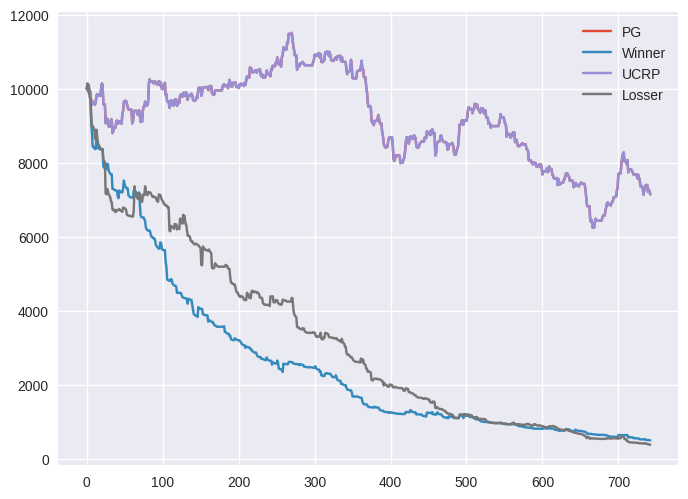

In [0]:
runTest()

In [0]:
!ls chinaresult

PG
